In [31]:
import os
import logging
import sys
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt

from simsopt.field.boozermagneticfield import (
        BoozerRadialInterpolant,
        InterpolatedBoozerField,
        ShearAlfvenHarmonic,
        ShearAlfvenWavesSuperposition
        )
from simsopt._core.util import parallel_loop_bounds
from simsopt.field.tracing import (
        MaxToroidalFluxStoppingCriterion,
        MinToroidalFluxStoppingCriterion,
        IterationStoppingCriterion,
        trace_particles_boozer_perturbed
)
from simsopt.util.constants import (
        ALPHA_PARTICLE_MASS as MASS,
        ALPHA_PARTICLE_CHARGE as CHARGE,
        FUSION_ALPHA_PARTICLE_ENERGY as ENERGY
)
from booz_xform import Booz_xform
from stellgap import AE3DEigenvector, saw_from_ae3d
import stellgap as sg
from scipy import integrate
from matplotlib.cm import ScalarMappable



# ---------- ASSUMPTIONS ------------
tracing = "gc_vac"
tol = 1e-10
resolution = 15

In [33]:
import simsoptpp as sopp

bump_multi = 1000

filename = 'boozmn_precise_QH.nc'
ic_folder = 'initial_conditions'


### -------------- GPU SAW ------------

saw_filename = 'mode/1st.npy'
saw_data = np.load(saw_filename, allow_pickle=True)
saw_data = saw_data[()]
saw_omega = 1000*np.sqrt(saw_data['eigenvalue'])
print("omega=", saw_omega)
s = saw_data['s_coords']
saw_srange = (s[0], s[-1], len(s))
saw_m = np.ascontiguousarray([x[0] for x in saw_data['harmonics']])
saw_n = np.ascontiguousarray([x[1] for x in saw_data['harmonics']])
saw_phihats = bump_multi * np.ascontiguousarray(np.column_stack([x[2].T for x in saw_data['harmonics']]))
saw_nharmonics = len(saw_m)

logging.basicConfig()
logger = logging.getLogger('simsopt.field.tracing')

s_init = np.loadtxt(f'{ic_folder}/s0.txt', ndmin=1)
theta_init = np.loadtxt(f'{ic_folder}/theta0.txt', ndmin=1)
zeta_init = np.loadtxt(f'{ic_folder}/zeta0.txt', ndmin=1)
vpar_init = np.loadtxt(f'{ic_folder}/vpar0.txt', ndmin=1)
# s_init = s_init[:1]
# theta_init = theta_init[:1]
# zeta_init = zeta_init[:1]
# vpar_init = vpar_init[:1]
points = np.zeros((s_init.size, 3))
points[:, 0] = s_init
points[:, 1] = theta_init
points[:, 2] = zeta_init
points = np.ascontiguousarray(points)
vpar_init = np.ascontiguousarray(vpar_init)

t1 = time.time()
equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(filename)
nfp = equil.nfp

omega= 32935.740465336436


In [34]:
### ------------------- CPU SAW ----------------
eigenvector = AE3DEigenvector.load_from_numpy(filename=saw_filename)
omega = np.sqrt(eigenvector.eigenvalue)*1000


bri = BoozerRadialInterpolant(
    equil=equil,
    order=3,
    no_K=False,
    N = nfp * -1
)

field = InterpolatedBoozerField(
        field=bri,
        degree=3,
        srange=(0, 1, resolution),
        thetarange=(0, np.pi, resolution),
        zetarange=(0, 2 * np.pi / nfp, resolution),
        extrapolate=True,
        nfp=nfp,
        stellsym=True,
        initialize=['modB','modB_derivs']
)

harmonic_list = []
for harmonic in eigenvector.harmonics:
    sbump = eigenvector.s_coords
    bump = harmonic.amplitudes
    sah = ShearAlfvenHarmonic(
        Phihat_value_or_tuple=(sbump, bump_multi*bump),
        Phim=harmonic.m,
        Phin=harmonic.n,
        omega=omega,
        phase=0.0,
        B0=field
    )
    harmonic_list.append(sah)
saw = ShearAlfvenWavesSuperposition(harmonic_list)

Phim=eigenvector.harmonics[0].m
Phin=eigenvector.harmonics[0].n

In [35]:
# Evaluate error in interpolation
print('Error in |B| interpolation', 
    field.estimate_error_modB(1000),
    flush=True)

VELOCITY = np.sqrt(2*ENERGY/MASS)

# set up GPU interpolation grid
def gen_bfield_info(field, srange, trange, zrange):

	s_grid = np.linspace(srange[0], srange[1], srange[2])
	theta_grid = np.linspace(trange[0], trange[1], trange[2])
	zeta_grid = np.linspace(zrange[0], zrange[1], zrange[2])

	quad_pts = np.empty((srange[2]*trange[2]*zrange[2], 3))
	for i in range(srange[2]):
		for j in range(trange[2]):
			for k in range(zrange[2]):
				quad_pts[trange[2]*zrange[2]*i + zrange[2]*j + k, :] = [s_grid[i], theta_grid[j], zeta_grid[k]]


	field.set_points(quad_pts)
	G = field.G()
	iota = field.iota()
	diotads = field.diotads()
	I = field.I()
	modB = field.modB()
	J = (G + iota*I)/(modB**2)
	maxJ = np.max(J) # for rejection sampling

	psi0 = field.psi0

	# Build interpolation data
	modB_derivs = field.modB_derivs()

	dGds = field.dGds()
	dIds = field.dIds()

	quad_info = np.hstack((modB, modB_derivs, G, dGds, I, dIds, iota, diotads))
	quad_info = np.ascontiguousarray(quad_info)

	return quad_info, maxJ, psi0

# generate grid with 15 simsopt grid pts
n_grid_pts = 15
srange = (0, 1, 3*n_grid_pts+1)
trange = (0, np.pi, 3*n_grid_pts+1)
zrange = (0, 2*np.pi/nfp, 3*n_grid_pts+1)
quad_info, maxJ, psi0 = gen_bfield_info(field, srange, trange, zrange)

nparticles = len(points)

Error in |B| interpolation (5.884996043641728e-05, 8.12636157739221e-05)


In [36]:
saw.B0.set_points(points)
mu_per_mass = (VELOCITY**2 - vpar_init**2) / (2 * saw.B0.modB()[:,0])
MU = MASS * mu_per_mass[0]

In [40]:
print(points)
print(vpar_init)

[[6.43670430e-01 3.78727399e+00 8.55900500e-01]
 [5.22276965e-01 5.59852742e+00 4.87096066e-01]
 [3.19042985e-02 4.05388573e+00 3.99506655e+00]
 [4.61106871e-01 5.99154091e+00 4.81580871e-03]
 [8.23107630e-01 2.56631506e+00 2.45078410e+00]
 [1.47470868e-01 3.33914476e+00 4.93994092e+00]]
[ -8852911.8683637   -2572312.84122503   3180973.46361786
 -10909205.19866671   9796655.05587024  -4908110.00960998]


In [41]:
cpu_gc_tys, cpu_gc_hits = trace_particles_boozer_perturbed(
        perturbed_field=saw,
        stz_inits=points[:1],
        parallel_speeds=vpar_init[:1],
        mus=mu_per_mass[:1],
        tmax=1e-3,
        mass=MASS,
        charge=CHARGE,
        Ekin=ENERGY,
        tol=tol,
        stopping_criteria=[
            MaxToroidalFluxStoppingCriterion(0.9)
        ],
        forget_exact_path=False,
        mode = tracing,
        axis=2
        )

cpu_traj = np.zeros(np.shape(cpu_gc_tys[0][:, :4]))
cpu_traj[:, 0] = cpu_gc_tys[0][:, 1]
cpu_traj[:, 1] = cpu_gc_tys[0][:, 2]
cpu_traj[:, 2] = cpu_gc_tys[0][:, 3]
cpu_traj[:, 3] = cpu_gc_tys[0][:, 0]
cpu_vpar = cpu_gc_tys[0][:, 4]



In [42]:
print(cpu_gc_tys[0][:5])

[[ 0.00000000e+00  6.43670430e-01 -2.49591132e+00  8.55900500e-01
  -8.85291187e+06  0.00000000e+00]
 [ 1.00000000e-06  6.41634825e-01 -1.93231349e+00  3.91706967e-01
  -9.08206725e+06  1.00000000e-06]
 [ 2.00000000e-06  6.41339467e-01 -1.35446754e+00 -8.37911515e-02
  -8.32584748e+06  2.00000000e-06]
 [ 3.00000000e-06  6.76959152e-01 -7.29890956e-01 -5.80358106e-01
  -7.53640869e+06  3.00000000e-06]
 [ 4.00000000e-06  6.58696487e-01 -6.72202163e-02 -1.07820932e+00
  -8.15733344e+06  4.00000000e-06]]


In [43]:
last_time = sopp.gpu_tracing_saw(
	quad_pts=quad_info, 
	srange=srange,
	trange=trange,
	zrange=zrange, 
	stz_init=points,
	m=MASS, 
	q=CHARGE, 
	vtotal=VELOCITY,  
	vtang=vpar_init, 
	tmax=1e-3, 
	tol=1e-10, 
	psi0=psi0, 
	nparticles=nparticles,
	saw_srange=saw_srange,
	saw_m=saw_m,
	saw_n=saw_n,
	saw_phihats=saw_phihats,
	saw_omega=saw_omega,
	saw_nharmonics=saw_nharmonics, dt_save=1e-6)

In [44]:
last_time = np.asanyarray(last_time, dtype=float)

def split_nonzero_runs(x):
    # boolean mask of non‑zeros
    mask = x != 0
    if not mask.any():
        return []

    # compute where mask changes: +1 marks a start, -1 marks an end
    diff = np.diff(mask.astype(int))
    starts = np.where(diff ==  1)[0] + 1
    ends   = np.where(diff == -1)[0]

    # if the very first element is non‑zero, that's a start
    if mask[0]:
        starts = np.r_[0, starts]
    # if the very last element is non‑zero, that's an end
    if mask[-1]:
        ends = np.r_[ends, mask.size - 1]

    # now slice out each run [s:e]
    return [ x[s:e+1] for s, e in zip(starts, ends) ]


# example
gpu_gc_tys = split_nonzero_runs(last_time)

In [45]:
for i in range(len(gpu_gc_tys)):
    gpu_gc_tys[i] = np.reshape(gpu_gc_tys[i], (-1, 5))

In [46]:
print(gpu_gc_tys[0][:5])

[[ 6.41634821e-01 -1.93231348e+00  3.91706964e-01 -9.08206732e+06
   1.00000000e-06]
 [ 6.41339457e-01 -1.35446753e+00 -8.37911622e-02 -8.32584758e+06
   2.00000000e-06]
 [ 6.76959144e-01 -7.29890900e-01 -5.80358124e-01 -7.53640887e+06
   3.00000000e-06]
 [ 6.58696446e-01 -6.72201057e-02 -1.07820935e+00 -8.15733375e+06
   4.00000000e-06]
 [ 5.63725884e-01  5.01939869e-01 -1.55837177e+00 -8.99487421e+06
   5.00000000e-06]]


In [47]:
def saw_Pzeta_Eprime_calc(saw,points,vpar):
    saw.set_points(points)
    modB = saw.B0.modB()[:,0]
    G = saw.B0.G()[:,0]
    if tracing == "gc_vac":
        I = 0
        G = np.mean(G)
    else:
        I = saw.B0.I()[:,0]
    # I = 0
    psi = saw.B0.psi0 * points[:, 0]
    psip = saw.B0.psip()[:,0]
    alpha = saw.alpha()[:,0]
    phi = saw.Phi()[:,0]

    Energy = 0.5*MASS*vpar**2 + MU * modB + CHARGE*phi
    # print(vpar, modB, CHARGE*phi)

    Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
    # Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
    

    Eff = (Phin-helicity*nfp*Phim)*Energy-omega*Pzeta
    return Energy,Pzeta,Eff


In [48]:
gpu_traj = np.zeros(np.shape(gpu_gc_tys[0][:, :4]))
gpu_traj[:, 0] = gpu_gc_tys[0][:, 0]
gpu_traj[:, 1] = gpu_gc_tys[0][:, 1]
gpu_traj[:, 2] = gpu_gc_tys[0][:, 2]
gpu_traj[:, 3] = gpu_gc_tys[0][:, 4]
gpu_vpar = gpu_gc_tys[0][:, 3]


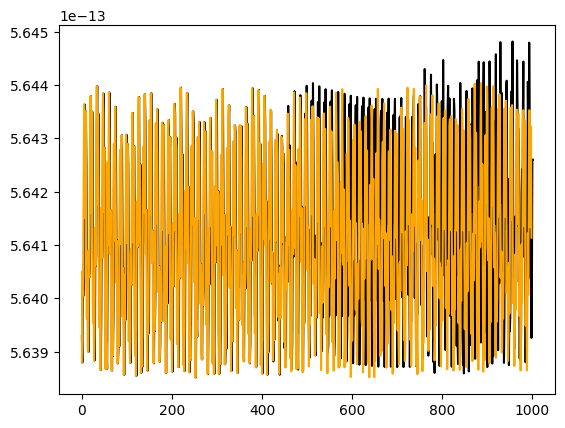

In [49]:
helicity = -1

cpu_E, cpu_Pz, cpu_Ep = saw_Pzeta_Eprime_calc(saw, cpu_traj, cpu_vpar)
gpu_E, gpu_Pz, gpu_Ep = saw_Pzeta_Eprime_calc(saw, gpu_traj, gpu_vpar)

plt.plot(cpu_E, color="black")
plt.plot(gpu_E, color="orange")

In [50]:
peturbed = ["cpu", "gpu"]
names = ["E", "Pzeta", "Eprime"]
quantities = [[cpu_E, cpu_Pz, cpu_Ep], [gpu_E, gpu_Pz, gpu_Ep]]


for i in range(2):
    for j in range(3):
        percent = (quantities[i][j] - quantities[i][j][0])/quantities[i][j][0]
        init_value = quantities[i][j][0]
        print(f"{peturbed[i]} {names[j]}: Conserved to {-np.log10(np.max(np.abs(percent)))} digits")


cpu E: Conserved to 3.008941706663748 digits
cpu Pzeta: Conserved to 0.758228872980777 digits
cpu Eprime: Conserved to 5.645468128949136 digits
gpu E: Conserved to 3.0319508784182765 digits
gpu Pzeta: Conserved to 0.7880670979214062 digits
gpu Eprime: Conserved to 5.697942465111823 digits


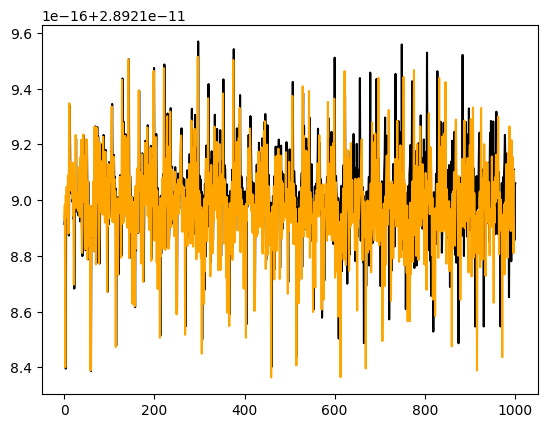

In [51]:
plt.plot(cpu_Ep, color="black")
plt.plot(gpu_Ep, color="orange")

In [30]:
np.savetxt(f"vac_traced_gpu_{tol}_{resolution}_{bump_multi}", gpu_gc_tys[0])
np.savetxt(f"vac_traced_cpu_{tol}_{resolution}_{bump_multi}", cpu_gc_tys[0])

NameError: name 'points' is not defined